# Setup

In [22]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pyarrow.feather as feather
from sklearn.cluster import DBSCAN
from matplotlib import colors as mcolors
import random

In [23]:
#set all plots to the same size and style
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

figure_counter = 0

In [24]:
storage_path = 'C:/Users/janle/Desktop/Master/1/BA_files'
raw_data = pd.read_csv(storage_path + '/Trips_2018.csv', index_col=0)

In [25]:
data = raw_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17548339 entries, 0 to 17548338
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start_station_id         float64
 4   start_station_latitude   float64
 5   start_station_longitude  float64
 6   end_station_id           float64
 7   end_station_latitude     float64
 8   end_station_longitude    float64
 9   bikeid                   int64  
 10  usertype                 object 
 11  birth_year               int64  
 12  gender                   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.8+ GB


In [26]:
data.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender
count,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07
mean,9.887432e+02,1.589282e+03,4.073737e+01,-7.398260e+01,1.580830e+03,4.073704e+01,-7.398281e+01,2.656141e+04,1.978993e+03,1.148613e+00
std,1.889584e+04,1.439432e+03,3.225813e-02,1.912753e-02,1.438502e+03,3.206583e-02,1.919611e-02,6.222916e+03,1.192922e+01,5.438043e-01
min,6.100000e+01,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.580000e+02,3.800000e+02,4.071755e+01,-7.399521e+01,3.800000e+02,4.071755e+01,-7.399595e+01,2.029300e+04,1.969000e+03,1.000000e+00
50%,6.050000e+02,5.050000e+02,4.073818e+01,-7.398565e+01,5.050000e+02,4.073756e+01,-7.398602e+01,2.827000e+04,1.981000e+03,1.000000e+00
75%,1.060000e+03,3.249000e+03,4.075763e+01,-7.397283e+01,3.249000e+03,4.075725e+01,-7.397344e+01,3.185200e+04,1.989000e+03,1.000000e+00
max,1.951005e+07,3.721000e+03,4.550636e+01,-7.356891e+01,3.721000e+03,4.550636e+01,-7.356891e+01,3.583100e+04,2.002000e+03,2.000000e+00


# Data Processing

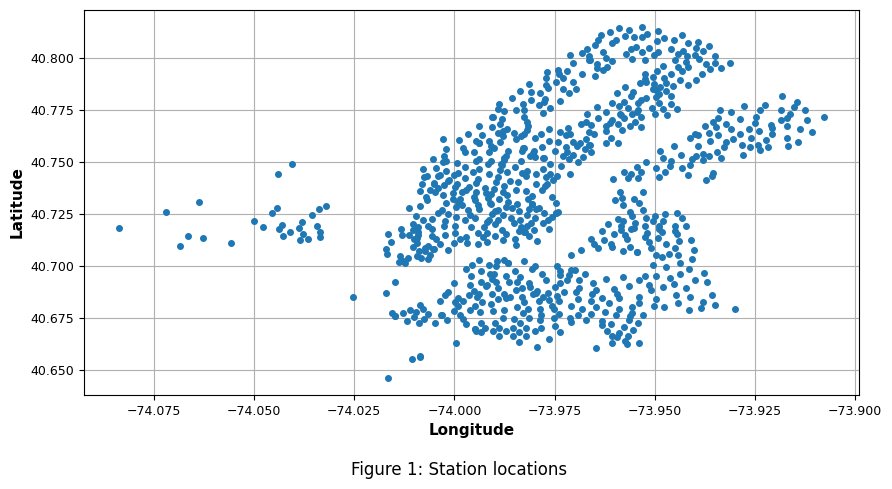

In [27]:
plt.figure()
plt.scatter(stations['longitude'], stations['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Station locations', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

## Missing Data

In [28]:
# Group by 'id' and count unique combinations of longitude and latitude
start_stations = data.groupby(['start_station_id', 'start_station_latitude', 'start_station_longitude']).size().reset_index(name='counter_start')
end_stations = data.groupby(['end_station_id', 'end_station_latitude', 'end_station_longitude']).size().reset_index(name='counter_end')

#rename columns for both dataframes to one name
start_stations.rename(columns={'start_station_id': 'station_id', 'start_station_latitude': 'latitude', 'start_station_longitude': 'longitude'}, inplace=True)
end_stations.rename(columns={'end_station_id': 'station_id', 'end_station_latitude': 'latitude', 'end_station_longitude': 'longitude'}, inplace=True)

# concatenate the two dataframes
stations = pd.concat([start_stations, end_stations])

stations = stations.groupby(['station_id', 'latitude', 'longitude']).sum().reset_index()
stations['counter_end'] = stations['counter_end'].astype(int)
stations['counter_start'] = stations['counter_start'].astype(int)

stations.describe()

,station_id,latitude,longitude,counter_start,counter_end
count,851.000000,851.000000,851.000000,851.000000,851.000000
mean,2369.844888,40.743663,-73.973498,20617.910693,20617.910693
std,1422.403023,0.234665,0.033669,20491.571805,20659.722804
min,72.000000,40.646538,-74.083639,0.000000,1.000000
25%,466.500000,40.699845,-73.992526,5721.000000,5702.000000
50%,3185.000000,40.730260,-73.976206,12989.000000,13108.000000
75%,3470.500000,40.763473,-73.953907,30393.500000,30700.500000
max,3721.000000,45.506364,-73.568906,150257.000000,149932.000000


## Formatting

In [29]:
# Define the format of your input string
date_format = "%Y-%m-%d %H:%M:%S.%f"

# Convert the string to a datetime object
data['starttime'] = pd.to_datetime(data['starttime'], format=date_format)
data['stoptime'] = pd.to_datetime(data['stoptime'], format=date_format)

data['birth_year'] = 2018 - data['birth_year']
data = data.rename(columns={'birth_year': 'age'})

data['usertype'] = data['usertype'].astype('string')

# Define a function to apply the condition and convert to 1 or 0
def condition_to_binary(value):
    return 1 if value == 'Subscriber' else 0

# Apply the function to create the 'Result' column
data['usertype'] = data['usertype'].apply(condition_to_binary)

## Filtering

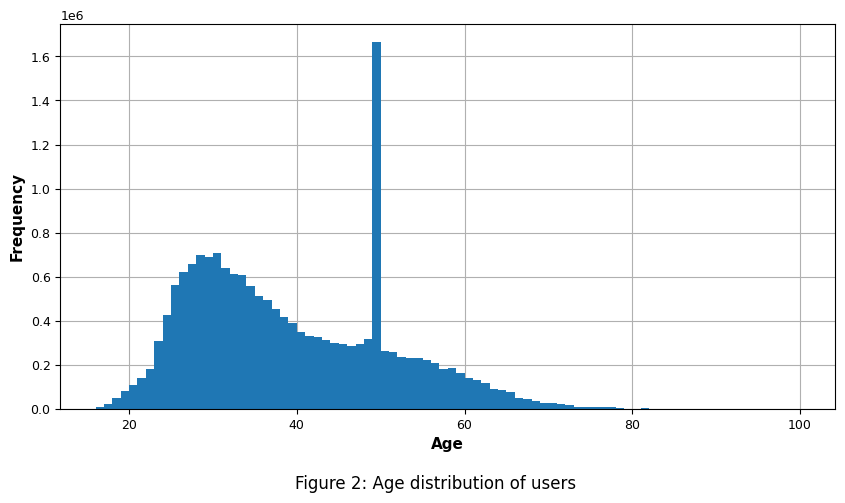

In [30]:
data = data[data['age'] <= 100]
plt.figure()
plt.hist(data['age'], bins=84)
plt.xlabel('Age')
plt.ylabel('Frequency')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Age distribution of users', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

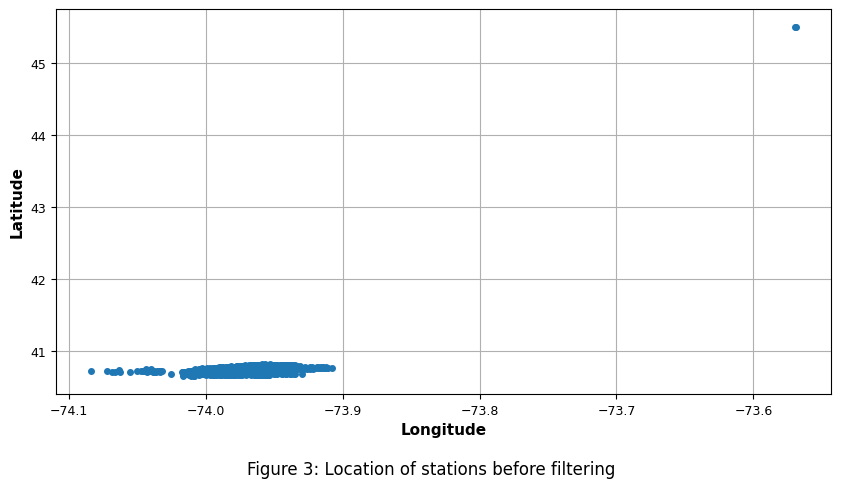

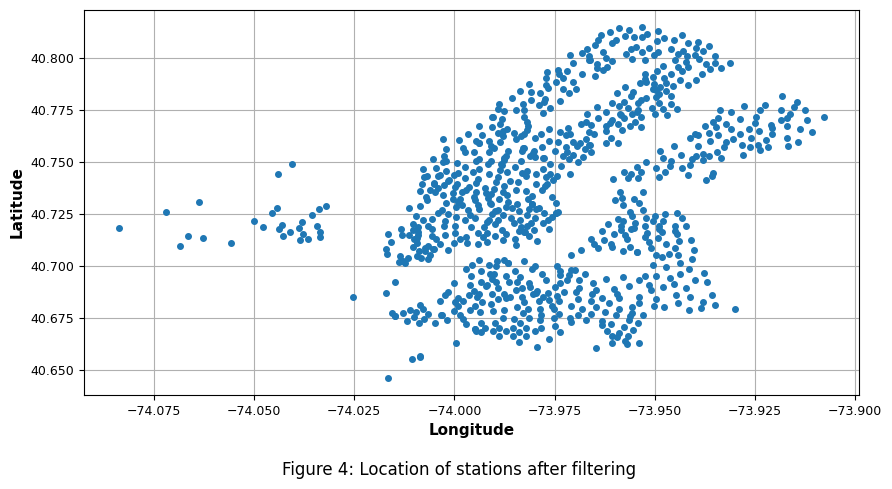

In [31]:


plt.figure()
plt.scatter(stations['longitude'], stations['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Location of stations before filtering', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

data = data[data['start_station_latitude'] <= 42]
data = data[data['end_station_latitude'] <= 42]
stations = stations[stations['latitude'] <= 42]

plt.figure()
plt.scatter(stations['longitude'], stations['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Location of stations after filtering', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

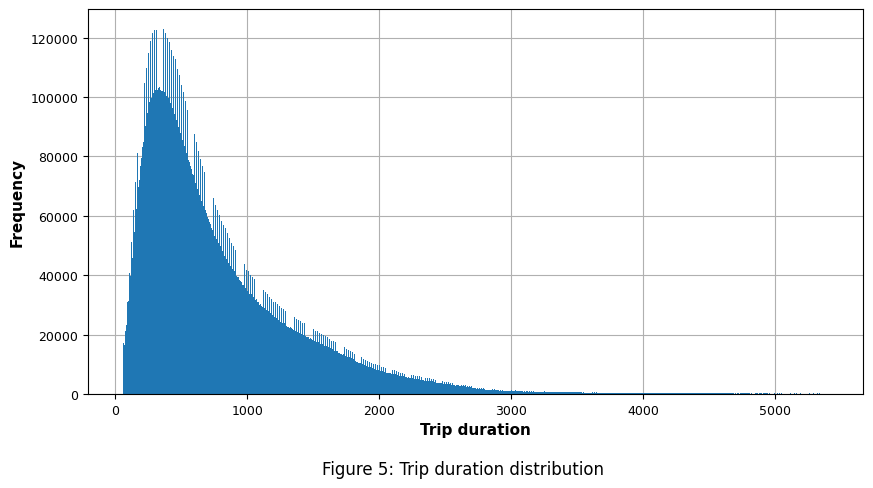

In [32]:
#Assuming that trips longer than 1,5 hours are manipulating the model. Could be even more reduced to 5400
data = data[data['tripduration']<5400]

plt.figure()
plt.hist(data['tripduration'], bins=1000)
plt.xlabel('Trip duration')
plt.ylabel('Frequency')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Trip duration distribution', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

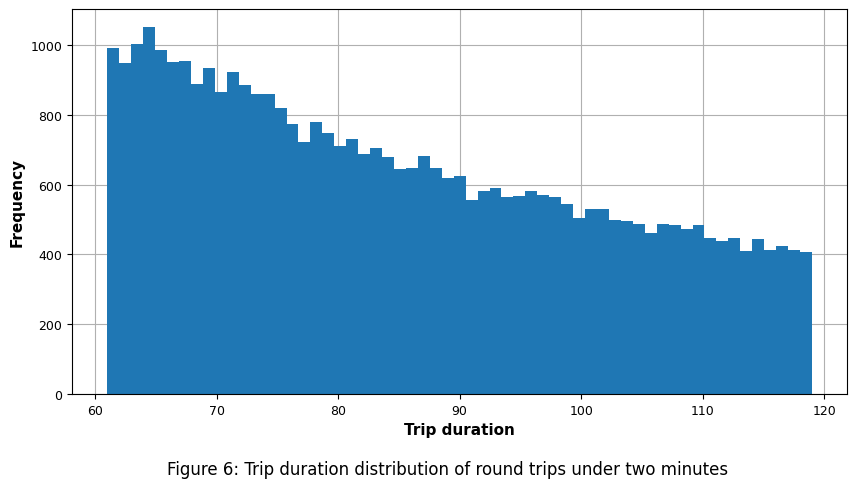

In [33]:
round_trips = data[data['start_station_id']==data['end_station_id']]
round_trips = round_trips[round_trips['tripduration']<120]

plt.figure()
plt.hist(round_trips['tripduration'], bins=59)
plt.xlabel('Trip duration')
plt.ylabel('Frequency')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Trip duration distribution of round trips under two minutes', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

condition = (data['tripduration']<120) & (data['start_station_id']==data['end_station_id'])
data = data[~condition]

In [34]:
data.to_feather(storage_path+"/cleaned_data.feather")
stations.to_feather(storage_path+"/cleaned_stations.feather")

# Descriptive study

# Clustering

In [35]:
storage_path = 'C:/Users/janle/Desktop/Master/1/BA_files'
# Read the Feather file into a DataFrame
df = feather.read_feather(storage_path + '/cleaned_data.feather')
stations = feather.read_feather(storage_path + '/cleaned_stations.feather')

In [36]:
stations.describe()

,station_id,latitude,longitude,counter_start,counter_end
count,849.000000,849.000000,849.000000,849.000000,849.000000
mean,2367.020024,40.732443,-73.974450,20666.385159,20666.383981
std,1422.879904,0.039678,0.027383,20491.311445,20659.860713
min,72.000000,40.646538,-74.083639,0.000000,1.000000
25%,466.000000,40.699773,-73.992663,5746.000000,5734.000000
50%,3184.000000,40.730207,-73.976289,12990.000000,13125.000000
75%,3468.000000,40.763414,-73.953990,30557.000000,30711.000000
max,3721.000000,40.814394,-73.907744,150257.000000,149932.000000


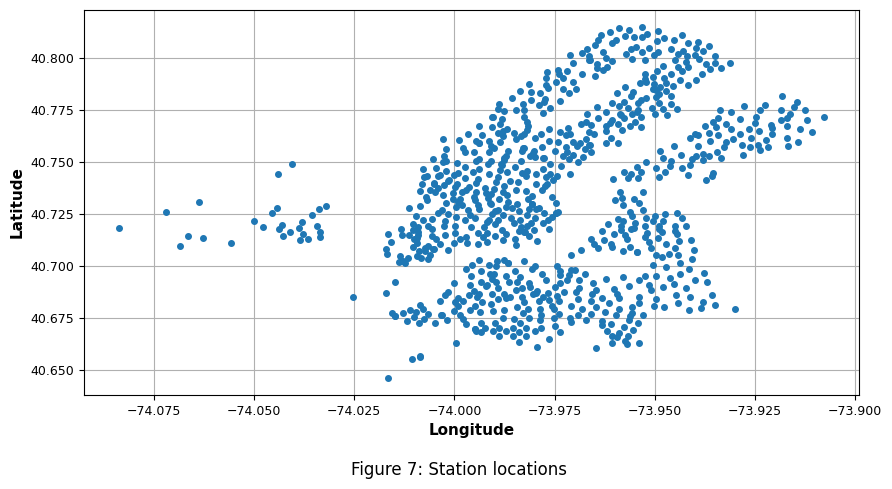

In [37]:
plt.figure()
plt.scatter(stations['longitude'], stations['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Station locations', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [38]:
combined_array = np.array([stations['latitude'], stations['longitude']]).T

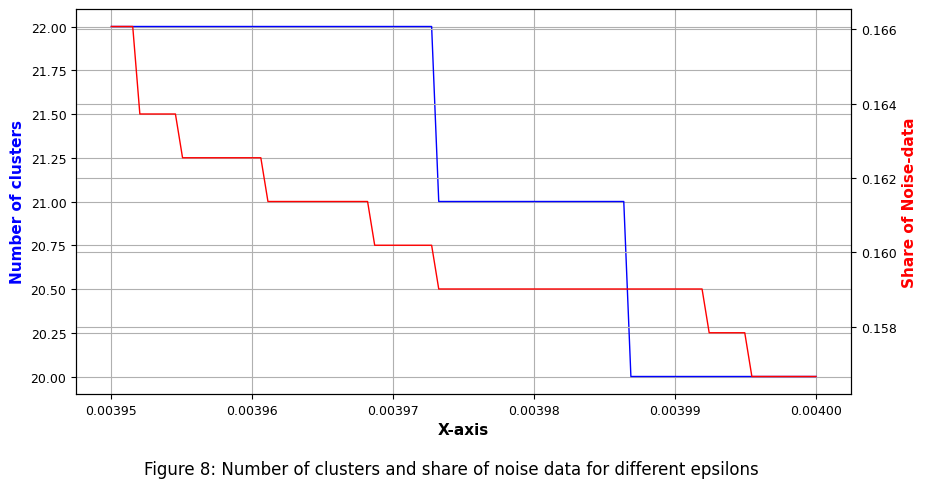

In [39]:
# DBSCAN
cluster_number = list()
noise_number = list()
esps = np.linspace(0.00395,0.004,100)

for i in esps:
    dbs=DBSCAN(eps=i) #(min_sample is the MinPts from the slides, eps is (guess what?) the epsilon)
    dbs.fit(combined_array)

    cluster_number.append(len(np.unique(dbs.labels_)))
    noise_number.append(list(dbs.labels_).count(-1)/len(stations))

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first set of data on the first y-axis
ax1.plot(esps, cluster_number, color='b', label='Y1')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Number of clusters', color='b')

# Create a second y-axis on the same x-axis
ax2 = ax1.twinx()
ax2.plot(esps, noise_number, color='r', label='Y2')
ax2.set_ylabel('Share of Noise-data', color='r')

figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Number of clusters and share of noise data for different epsilons', wrap=True, horizontalalignment='center', fontsize=12)
# Show the plot
plt.show()

The total number of cluster is  21
The labels/cluster are: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] (Noisy samples are given the label -1)


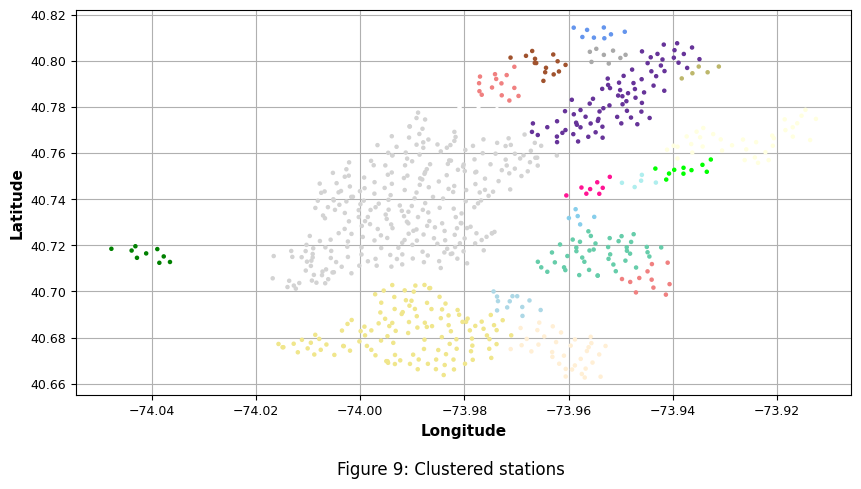

In [40]:
dbs=DBSCAN(eps=0.00398) #(min_sample is the MinPts from the slides, eps is (guess what?) the epsilon)
dbs.fit(combined_array)

print('The total number of cluster is ', len(np.unique(dbs.labels_)))
print('The labels/cluster are:', np.unique(dbs.labels_), '(Noisy samples are given the label -1)')

num_colors=len(set(dbs.labels_))-1   #it's the number of different labels except for 1 (the -1 label)
colors=list(mcolors.CSS4_COLORS.keys())  #found this by searching "python color list"
cluster_colors=random.choices(colors, k=num_colors)

x_=[]
y_=[]
c_=[]
help_labels = list()
for label, x, y in zip(dbs.labels_, combined_array[:,1], combined_array[:,0]):
    if label==-1:
        continue
    x_.append(x)
    y_.append(y)
    c_.append(cluster_colors[label])
    help_labels.append(label)

d = {'longitude': x_, 'latitude': y_, 'cluster': help_labels}
clustered_stations = pd.DataFrame(data=d)
clustered_stations = pd.merge(stations, clustered_stations, how='left', left_on=['longitude', 'latitude'], right_on=['longitude', 'latitude'])

start_trip_clustered = pd.merge(df,clustered_stations,how='left', left_on='start_station_id', right_on='station_id').drop(['station_id', 'latitude', 'longitude'], axis=1)
end_trip_clustered = pd.merge(df,clustered_stations,how='left', left_on='end_station_id', right_on='station_id').drop(['station_id', 'latitude', 'longitude'], axis=1)

plt.figure()
plt.scatter(x_,y_,s=5,c=c_)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Clustered stations', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

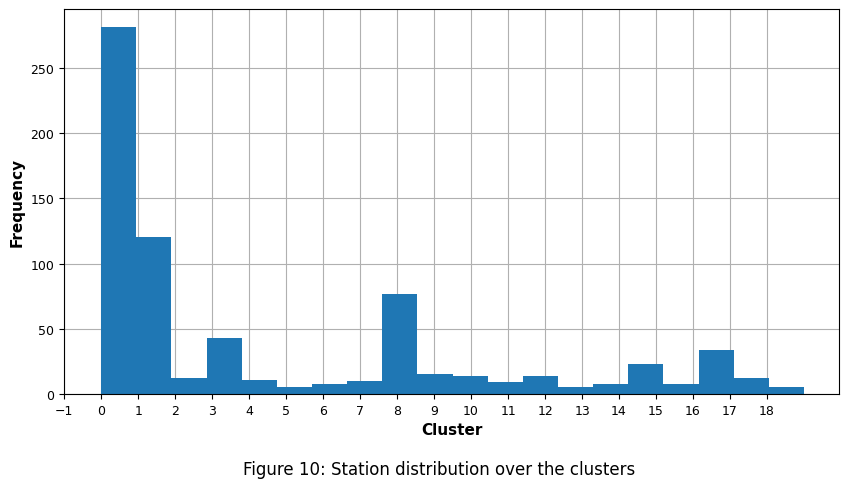

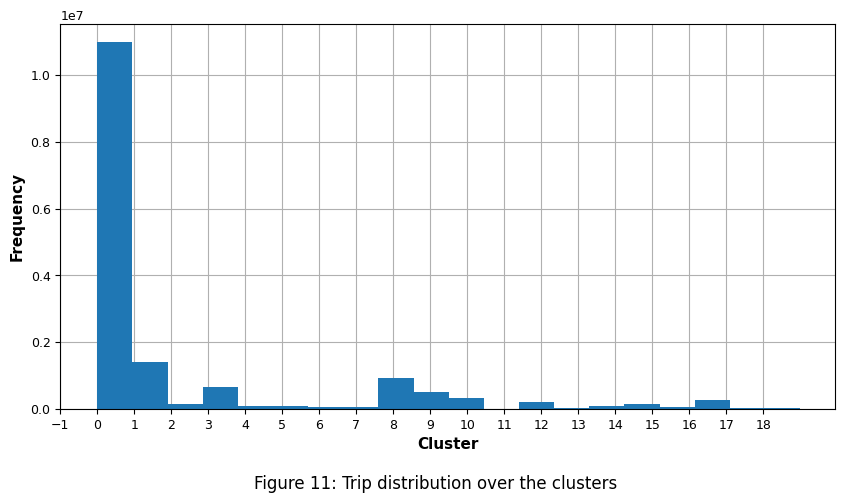

In [41]:
d = {'longitude': x_, 'latitude': y_, 'cluster': help_labels}
clustered_stations = pd.DataFrame(data=d)
clustered_stations = pd.merge(stations, clustered_stations, how='left', left_on=['longitude', 'latitude'], right_on=['longitude', 'latitude'])

start_trip_clustered = pd.merge(df,clustered_stations,how='left', left_on='start_station_id', right_on='station_id').drop(['station_id', 'latitude', 'longitude'], axis=1)
end_trip_clustered = pd.merge(df,clustered_stations,how='left', left_on='end_station_id', right_on='station_id').drop(['station_id', 'latitude', 'longitude'], axis=1)
#plot histogram of cluster_stations['cluster'] as a nice histogram
plt.figure()
plt.hist(clustered_stations['cluster'], bins=len(np.unique(dbs.labels_))-1)
plt.xticks(np.arange(-1, len(np.unique(dbs.labels_))-2, 1))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Station distribution over the clusters', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# sam plot for start_trip_clustered['cluster']
plt.figure()
plt.hist(start_trip_clustered['cluster'], bins=len(np.unique(dbs.labels_))-1)
plt.xticks(np.arange(-1, len(np.unique(dbs.labels_))-2, 1))
plt.xlabel('Cluster')
plt.ylabel('Frequency')
figure_counter +=1
plt.figtext(0.5, -0.05, f'Figure {figure_counter}: Trip distribution over the clusters', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()